# Burst class for MINBAR

This code is a preliminary attempt to develop a burst class for MINBAR, including model-observation comparisons. 

The first type of implementation we want to include is the "reference" bursts, which have a format like this:

    #
    # Columns are:
    # 'Time [s]' 'dt [s]' 'flux [10^-9 erg/cm^2/s]' 'flux error [10^-9 erg/cm^2/s]' 'blackbody temperature kT [keV]' 'kT error [keV]' 'blackbody normalisation K_bb [(km/d_10kpc)^2]' 'K_bb error [(km/d_10kpc)^2]' chi-sq
     -1.750  0.500   1.63    0.054   1.865  0.108   13.891   4.793  0.917
     -1.250  0.500   2.88    1.005   1.862  0.246   22.220   4.443  1.034
     -0.750  0.500   4.38    1.107   1.902  0.093   30.247   2.943  1.089
     -0.250  0.500   6.57    0.463   1.909  0.080   46.936   6.969  0.849

We ultimately want to run the comparison step in mlfit, which is invoked with something like this:

    params, uparams, ms, chisq, goodParams = lcCompare(burstFile,obsfile,plot=True)

Here we demonstrate the usage of the class. We now collect the class definitions and related functions in the file burstclass.py, which can be imported as shown. First we define an observed burst, as well as a model burst, and then compare one to the other. At present this is limited to overplotting them and calculating the combined likelihood

1 gs1826-24_4.177h.dat ../../burst/reference/gs1826-24_4.177h.dat
its an observed burst
4.177 h 0.01 h
1.1259999999999999e-06 erg / (cm2 s) 1.6e-08 erg / (cm2 s)
1.787 0.003


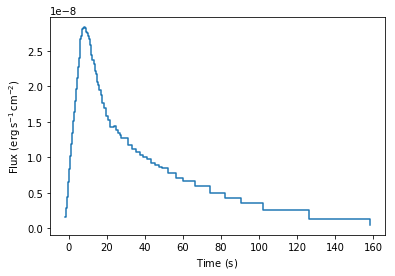

In [3]:
from burstclass import *
from anisotropy import *

# help (ObservedBurst)

# Read in an observed burst

# b = ObservedBurst('../../reference/gs1826-24_4.177h.dat')
b = ObservedBurst('../../burst/reference/gs1826-24_4.177h.dat')

if type(b) == ObservedBurst:
    print ('its an observed burst')

# Show the recurrence time and other parameters, added from the .tex table

print (b.tdel,b.tdel_err)
print (b.fluen,b.fluen_err)
print (b.cbol,b.cbol_err)

# Here the plot method is inherited from the daughter class
# but doesn't work yet for the model burst class (because of the flux issue)

% matplotlib inline

b.plot()

# this will do nothing, because the filename tag is not given
# c = Lightcurve('../../reference/gs1826-24_4.177h.dat')

Help on class KeplerBurst in module burstclass:

class KeplerBurst(Lightcurve)
 |  Test class for a burst lightcurve
 |  
 |  Method resolution order:
 |      KeplerBurst
 |      Lightcurve
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, run_id, path=None)
 |      initialise the object by assigning named entities from the kwargs
 |  
 |  flux(self, dist)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Lightcurve:
 |  
 |  plot(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from Lightcurve:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)

25 3.390000104904175 h 0.07999999821186066 h 0.082
<class 'astropy.units.quantity.Quantity'>
0.082 1.4350000396370887e-09 1 / yr
<class 'burstclass.KeplerBurst'> ../../burst/reference/kepler_

-6031.0323337609889

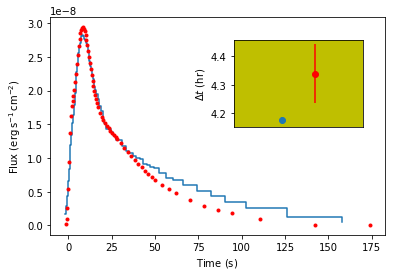

In [3]:
help (KeplerBurst)

# Now also define a model burst. Note the difference in syntax

# c = ModelBurst('a005',path='../../reference')
c = KeplerBurst('a028',path='../../burst/reference')
print (c.row,c.tdel,c.tdel_err,c.Lacc)
print (type(c.tdel))
# print (hasattr(c,'Lacc'))
print (c.Lacc, c.mdot/const.M_sun)
print (type(c), c.filename)
if isinstance(c,KeplerBurst):
    print ('we have a Kepler model burst')
#    print (c.data.columns)
    
# Here we try to do a simple comparison

#print (c.flux(6.*u.kpc))
b.compare(c,(6.1*u.kpc,60.*u.degree,1.28,-6.5*u.s),plot=True)

In [4]:
print (c.comments)

['kepler_a028_mean.txt', '', 'Mean burst simulation for model a028', 'See the reference paper Lampe, Galloway & Heger (in prep.)', 'for further information on model preartion and analysis', 'Errors reported are 1 sigma std-dev of stacked models', 'Models created by Alexander Heger <heger@monash.edu>', 'Analysis done by Nathanael Lampe <lampe@clermont.in2p3.fr>', 'Accretion Rate (x10^-9 M_sun yr^-1): 1.435000', 'Accretion luminosity (l/L_Edd): 0.082000', 'H fraction: 70.480000', 'Z fraction: 2.000000', 'time (s), luminosity (1e37 ergs/s), u(luminosity), radius (km), u(radius)']


# Incorporating mlfit.py

Here we want to modify Nathanael's mlfit.py code, to do the fitting, using the burst Class. The main focus is the routine lcCompare, which calls emcee. The sequence is

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lhood, args=[modelFunc, x, y, dy, flatPriors, [cent,span] ])
    
where lhood is the likelihood function. So need to
* modify the lhood function to accept members of the burst class (both observed and modeled) as arguments

(This was my original idea; but I've since re-written modelFunc, and incorporated it into the compare method for the bursts. See above)

Remaining code below is for testing and development of the modelFunc function, now largely incorporated into the compare method

** WARNING ** assuming inclination in degrees
[  2.85538060e-10   2.97054777e-10   3.12106999e-10   3.33065123e-10
   7.77755862e-10   5.25793876e-09   1.37702750e-08   2.68167994e-08
   3.89079195e-08   4.45742363e-08   4.72689462e-08   4.97105471e-08
   5.29755017e-08   5.71009451e-08   6.16434530e-08   6.60353495e-08
   6.97586716e-08   7.25409299e-08   7.41843609e-08   7.47432612e-08
   7.42414498e-08   7.28932467e-08   7.09069767e-08   6.84380594e-08
   6.56624157e-08   6.27082389e-08   5.97477521e-08   5.69044069e-08
   5.42506719e-08   5.18342836e-08   4.96390098e-08   4.76836067e-08
   4.59723967e-08   4.44676877e-08   4.31592163e-08   4.20046437e-08
   4.10039923e-08   3.97280980e-08   3.83165746e-08   3.70919828e-08
   3.59563296e-08   3.49014657e-08   3.38487226e-08   3.28437334e-08
   3.17961270e-08   3.07877585e-08   2.97654257e-08   2.87738985e-08
   2.78134959e-08   2.58578756e-08   2.38940454e-08   2.21037469e-08
   2.04423642e-08   1.88810147e-08   1.74901307e-08   1.6

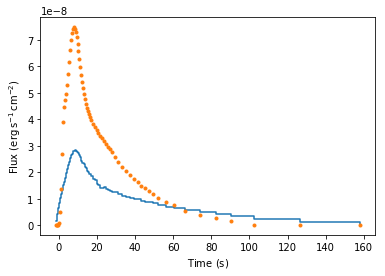

In [5]:
import sys
sys.path.append('/Users/duncan/burst/reference')
from mlfit import *

# some of the routines in mlfit are defined only once you run lcCompare

# from the code segment above got observed burst b and model burst c

# Parameter array is now a tuple with the appropriate units:
# ( distance, burst anisotropy, redshift, time offset )

p = (6.*u.kpc,1.,1.,-8.*u.s)

test = modelFunc(p,b,c)
print (test)
print (len(test),len(b.time),len(c.time))
print (test.unit == b.flux.unit)

# Compare the observed burst and the interpolated, rescaled model burst

# plt.plot(c.time,c.lumin,b.time,test,'.')
b.plot()
plt.plot(b.time,test,'.')
# dir(mlfit)

Cell below reads in all three data files, and identifies suitable model lightcurves for the comparison. We finish up with the obs and models tuples, which are next used for input to lhoodClass

In [8]:
# Assemble the observed and model data

path='../../burst/reference/'
b1 = ObservedBurst(path+'gs1826-24_3.530h.dat')
b2 = ObservedBurst(path+'gs1826-24_4.177h.dat')
b3 = ObservedBurst(path+'gs1826-24_5.14h.dat')
# print (type(b2))

# Calculate ratios of mdot relative to b2
# With LaTeX headers, it's a bit clumsy trying to get the mdot from the table

# print (b1.table[b1.row][r'$\dot{m}$ ($\dot{m}_{\rm Edd}$)'],
#       b2.table[b2.row][r'$\dot{m}$ ($\dot{m}_{\rm Edd}$)'],
#       b3.table[b3.row][r'$\dot{m}$ ($\dot{m}_{\rm Edd}$)'])

# but luckily we copied it (with physical units) to the mdot attribute

# print (b1.mdot/b2.mdot,b3.mdot/b2.mdot)
t1 = b1.mdot/b2.mdot
t3 = b3.mdot/b2.mdot
print ("Mdot ratio targets: ",t1,t3)

# Now assemble the observed burst tuple

obs = (b1,b2,b3)

# Define the model bursts. For the 4.177h burst, we already have a reasonable match with a028. 
# So need to get corresponding matches for the other two bursts

m2 = KeplerBurst('a028',path=path)
# print (m2.data[m2.row])
print (m2.mdot,m2.data[m2.row]['Lacc'])

# Get the rows that match the same conditions

same = np.where((m2.data['H'] == m2.data[m2.row]['H']) 
                & (m2.data['Z'] == m2.data[m2.row]['Z']))[0]
# print (len(same))
print (same)

# And finally find the model with the closest ratio of accretion rates to our targets

acc_ratio = m2.data['Lacc']/m2.data[m2.row]['Lacc']
print (len(acc_ratio))
best1 = np.argmin(abs(acc_ratio[same]-t1))
print (same[best1], m2.data['Lacc'][same][best1],acc_ratio[same][best1], t1, m2.data['model'][same][best1])

best3 = np.argmin(abs(acc_ratio[same]-t3))
print (same[best3], m2.data['Lacc'][same][best3],acc_ratio[same][best3], t3, m2.data['model'][same][best3])

# According to this code, the best choice of model for m1 is a005, which has a Lacc of 0.1 (confirmed)
# Similarly, for m3, the best choice is a019

m1 = KeplerBurst('a005',path=path)
m3 = KeplerBurst('a019',path=path)

# Can check some comparisons here

# b1.compare(m1,(6.1*u.kpc,60.*u.degree,1.28,-6.5*u.s),plot=True)
# b3.compare(m3,(6.1*u.kpc,60.*u.degree,1.28,-6.5*u.s),plot=True)

# And finally assemble the model burst tuple

models = (m1, m2, m3)

2 gs1826-24_3.530h.dat ../../burst/reference/gs1826-24_3.530h.dat
1 gs1826-24_4.177h.dat ../../burst/reference/gs1826-24_4.177h.dat
0 gs1826-24_5.14h.dat ../../burst/reference/gs1826-24_5.14h.dat
Mdot ratio targets:  1.1502890173410405 0.7413294797687862
2.854358578842133e+21 kg / yr 0.082
[ 2  3  6  8  9 10 11 12 16 18 19 20 21 22 23 24 25 28 29 30 31 32 33 34 35
 36]
50
2 0.1 1.21951 1.1502890173410405 b'a005'
16 0.067 0.817073 0.7413294797687862 b'a019'


In [9]:
# Now want to define a new likelihood function, based on the old one, but which can handle
# multiple pairs of observed bursts

def apply_units(params,units = (u.kpc, u.degree, None, u.s)):
    
# When called from emcee, the parameters array might not have units. So 
# apply them here, in a copy of params (uparams)

    ok = True
    uparams = []
    for i, param in enumerate(params):
#        print (i,param,units[i])
        if units[i] != None:
            if hasattr(param,'unit') == False:
                uparams.append(param*units[i])
#                print ("Applying unit to element ",i)
            else:
                uparams.append(param)
                if param.unit != units[i]:
                    ok = False
        else:
            uparams.append(param)
            if hasattr(param,'unit') == True:
                ok = False
#    print (params, uparams, ok)
    assert(ok == True)
    
    return uparams


def lhoodClass(params,obs,model):
    '''
    Calculate the likelihood related to one or more model-observation comparisons
    '''
    
    uparams = apply_units(params)
    
# We can pass multiple bursts, in which case we just loop over the function

    alh = 0.0

    if type(obs) == tuple:
        n = len(obs)
        if (n != len(model)):
            print ("** ERROR ** number of observed and model bursts don't match")
        
        for i in range(n):
            alh += lhoodClass(uparams,obs[i],model[i])
#            print (i,n,alh)

    else:
        
# Or if we have just one burst, here's what we do

        alh = obs.compare(model,uparams)
            
    return alh

# The corresponding call to emcee will (necessarily) look something like this

# sampler = emcee.EnsembleSampler(nwalkers, ndim, lhoodClass, args=[obs, models ])

-6022.80319761 -6022.80319761


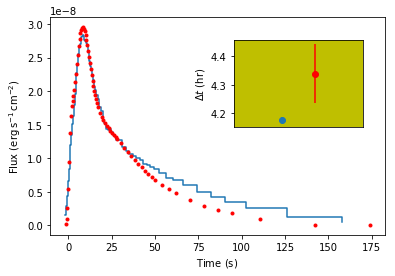

In [10]:
# Here some prelimiary testing of the lhoodClass function; this should 
# replicate the operation of the compare method for a single burst

params = (6.09*u.kpc,60.*u.degree,1.28,-6.5*u.s)

lh = b2.compare(m2,params,plot=True)
lh2 = lhoodClass(params,b2,m2)

# These should give the same results

print (lh,lh2)

In [11]:
# Now the real test, with a multiple burst comparison

params = (6.09*u.kpc,60.*u.degree,1.28,-6.5*u.s)

lh3 = lhoodClass(params,obs,models)
print ('Combined likelihood for all three models is ',lh3)

Combined likelihood for all three models is  -35818.3907482


Since we've come this far, we might as well try to run emcee with the new lhoodClass routine. We define the parameters and initialise the walkers in a small ball around those values. Then we run the chains (for a modest numer of steps, at least initially)

In [42]:
import emcee

# emcee doesn't like parameters with units, so let's omit them for now
# I've tweaked lhoodClass to make sure they are re-applied prior to the
# likelihood calculation

params = (6.09,60.,1.28,-6.5)

ndim, nwalkers = len(params), 200
pos = [params*(1+1e-3*np.random.randn(ndim)) for i in range(nwalkers)]

# Set up the walkers

# pos = []
# for i in range(nwalkers):
#     _params = [x*(1.+1e-4*np.random.randn()) for x in params]
#     pos.append(_params)
    
sampler = emcee.EnsembleSampler(nwalkers, ndim, lhoodClass, 
                                args=(obs,models))

# %timeit -n 1 -r 1 pos_new, lnprob, rstate = sampler.run_mcmc(pos,20)
# 1 loop, best of 1: 2min 18s per loop (100 walkers)

# ~8hr run
pos_new, lnprob, rstate = sampler.run_mcmc(pos,1900)

Now visualise the results

1440000


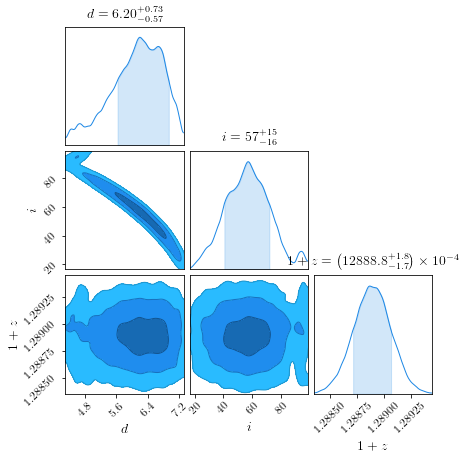

In [43]:
from chainconsumer import ChainConsumer

# Documentation is here https://samreay.github.io/ChainConsumer/index.html

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
print (np.size(samples))

# This to produce a much more beautiful plot

c = ChainConsumer()
c.add_chain(samples, parameters = [r"$d$",r"$i$",r"$1+z$"])#,r"$\Delta t$"])

# Nice plot of the walks

# c.plot_walks()

fig = c.plot()
fig.set_size_inches(6,6)

Also want a set of code to visualise the model comparisons

[<Quantity 6.080287602634114 kpc>, <Quantity 59.31627842456529 deg>, 1.2888947513728573, <Quantity -6.740222896024512 s>]
[ 3.53   4.177  5.14 ] [ 0.004  0.01   0.07 ] [ 3.46712695  4.36935334  5.51646981] [ 0.03866684  0.10311158  0.14177842]
<class 'numpy.ndarray'>
<class 'astropy.units.quantity.Quantity'> <class 'astropy.units.quantity.Quantity'>


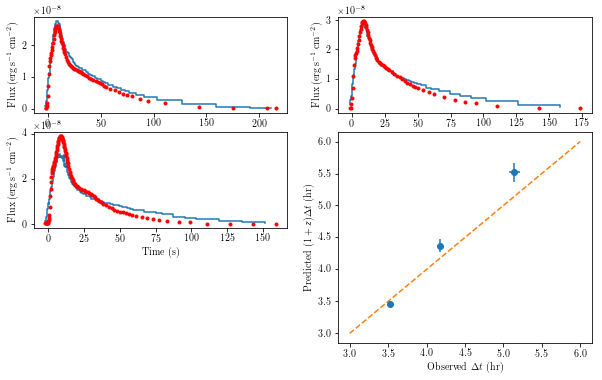

In [44]:
from matplotlib import gridspec

# Identify the maximum probability set of parameters

chain_shape = np.shape(sampler.lnprobability)
imax = np.argmax(sampler.lnprobability)
ibest = np.unravel_index(imax,chain_shape)

# print (imax,chain_shape,ibest)
prob_max = sampler.lnprobability[ibest]
_param_best = sampler.chain[ibest[0],ibest[1],:]

param_best = apply_units(_param_best)
print (param_best)

n = len(obs)

# See http://matplotlib.org/users/gridspec.html for documentation

fig = plt.figure()
gs = gridspec.GridSpec(3,2)

# plot the model comparisons

ax1 = fig.add_subplot(gs[0,0])
b1.compare(m1,param_best,plot=True,subplot=False)

ax2 = fig.add_subplot(gs[0,1])
b2.compare(m2,param_best,plot=True,subplot=False)

ax3 = fig.add_subplot(gs[1,0])
b3.compare(m3,param_best,plot=True,subplot=False)

x = np.zeros(n)
xerr = np.zeros(n)
y = np.zeros(n)
yerr = np.zeros(n)
for i, burst in enumerate(obs):
    x[i] = burst.tdel.value
    xerr[i] = burst.tdel_err.value
    y[i] = models[i].tdel.value*param_best[2]
    yerr[i] = models[i].tdel_err.value*param_best[2]

print (x,xerr,y,yerr)
print (type(x))

print (type(b1.tdel),type(m1.tdel))
ax4 = fig.add_subplot(gs[1:,-1])
ax4.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='o')
ax4.plot([3,6],[3,6],'--')
ax4.set_xlabel('Observed $\Delta t$ (hr)')
ax4.set_ylabel('Predicted $(1+z)\Delta t$ (hr)')

fig.set_size_inches(10,6)


# Random code snippets


91 (3, 91) (91,)
83.5 deg (0.56545735249216666, 0.023027982904217197, 0.10700591170743004) 1.69927768774 9.34527806963 (<Quantity 1.6307807551355935>, <Quantity 4.416835735998781>)
(<Quantity 1.6307807551355935>, <Quantity 4.416835735998781>) (1.6992776877378497, 9.3452780696280371)
** WARNING ** assuming inclination in degrees
(<Quantity 1.0>, <Quantity 0.9999999999999998>)


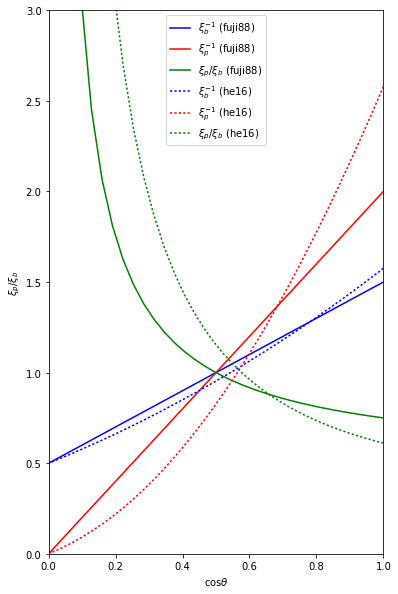

In [1]:
# Testing anisotropy.py

from anisotropy import *
from scipy.interpolate import interp1d

%matplotlib inline

a=ascii.read('anisotropy_he16.txt')
v=np.stack((a['col2'],a['col3'],a['col4']),axis=1).T
print (len(a['col1']),np.shape(v),np.shape(a['col1']))


# f = interp1d(a['col1'],a['col2'])
f = interp1d(a['col1'],v)
i_test = 83.5*u.degree
# print (83.5,f(83.5),anisotropy(83.5))
a, b, c = f(i_test)
print (i_test,(a,b,c),1./(a+b),1./c,anisotropy(i_test))

print (anisotropy(i_test),anisotropy(i_test,model='he16'))
print (anisotropy(60.,test=True))



In [ ]:
# testing decode_LaTeX

val, val_err = decode_LaTeX('$ 34.3 \pm 0.2$')
print (val,val_err)
val, val_err = decode_LaTeX('34.3')
print (val,val_err)

print (float('34.3'))

In [ ]:
from astropy.table import Table

# Here we can read in a simplified version of the table from the burst reference
# paper, so that we can associate the burst parameters with each lightcurve file

file = '/Users/duncan/burst/reference/doc/table2.tex'
tab = Table.read(file)
#tab['col0']

# Below we associate each epoch with a file

file=['gs1826-24_5.14h.dat',
      'gs1826-24_4.177h.dat',
      'gs1826-24_3.530h.dat',
      'saxj1808.4-3658_16.55h.dat',
      'saxj1808.4-3658_21.10h.dat',
      'saxj1808.4-3658_29.82h.dat',
      '4u1820-303_2.681h.dat',
      '4u1820-303_1.892h.dat',
      '4u1636-536_superburst.dat']

tab['file'] = file

# Test here that you can identify each of these with a provided filename

filename='../../reference/gs1826-24_4.177h.dat'
# lcfile='gs1826-24_4.177h.dat'
# print (re.search(lcfile,filename))
for i, lcfile in enumerate(tab['file']):
#    m = re.match(lcfile,filename)
    m = re.search(lcfile,filename)
#    m = re.match('\$([0-9]+\.[0-9]+).pm([0-9]+\.[0-9]+)',tab['$\Delta t$ (hr)'][i])
#    print (m.group(1),m.group(2))
#    print ("'"+lcfile+"'",type(lcfile),type(filename),m)
    if m != None:
        row=i
        print (i, lcfile, filename)

print (tab['$\Delta t$ (hr)'][row])
print (type(tab['$\Delta t$ (hr)'][row]))
print (re.search('\$([0-9]+\.[0-9]+)',tab['$\Delta t$ (hr)'][row]).group(1))
print (re.search('pm([0-9]+\.[0-9]+)',tab['$\Delta t$ (hr)'][row]).group(1))

# print (re.match('','$4.177\pm0.010$'))
tab['$\Delta t$ (hr)']
print (tab.columns[5:10])
label = ['cbol','mdot','fluen','F_pk','alpha'

In [ ]:
from astroquery.vizier import Vizier

catalogs = Vizier.find_catalogs('Lampe')
for name, catalog in catalogs.items():
    print(name, ':', catalog.description)

model_table = Vizier.get_catalogs('J/ApJ/819/46')
row = (model_table[0]['model'] == b'a006')
print (type(model_table[0]['model']))

# row=(model_table[0]['model'].quantity == 'a005')
print (model_table[0][row])

print (model_table[0].columns)
print (model_table[0]['tDel'].unit)
print (model_table[0]['Lacc'].unit)



In [ ]:
# Here we learn how to extract information from the burst summary table

file='/Users/duncan/Documents/2015/Nat new catalog/summ.csv'
data = ascii.read(file)
print (type(data))
print (type(data['model']))# == 'xrba005'
match = np.where(data['model'] == "'xrba005'")
print (data['model'][match],data['tDel'][match]/3600.,data['uTDel'][match]/3600.)
print (data.columns)
